# FARGOpy
## Wrapping FRAGO3D

## Tutorial: vector fields

<a target="_blank" href="https://colab.research.google.com/github/seap-udea/fargopy/blob/main/examples/fargopy-tutorial-vector_fields.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### What's in this notebook

In this notebook we illustrate **how to manipulate vector fields** in `FARGOpy`.

### Before starting

If you are in `Google Colab`, install the latest version of the package:

In [1]:
# @title Install fargopy
import sys
if 'google.colab' in sys.modules:
    !sudo pip install -Uq fargopy

For this tutorial you will need the following external modules and tools:

In [97]:
import fargopy as fp
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from celluloid import Camera
from tqdm import tqdm
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Let's `FARGOpy`

First we need the data. Let's download a precomputed simulation. Check the list:

In [3]:
fp.Simulation.list_precomputed()

fargo:
	Description: Protoplanetary disk with a Jovian planet in 2D
	Size: 55 MB
p3diso:
	Description: Protoplanetary disk with a Super earth planet in 3D
	Size: 220 MB
p3disof:
	Description: Protoplanetary disk with a a Super earth planet in 3D (increased resolution)
	Size: 440 MB
fargo_multifluid:
	Description: Protoplanetary disk with several fluids (dust) and a Jovian planet in 2D
	Size: 100 MB
binary:
	Description: Disk around a binary with the properties of Kepler-38 in 2D
	Size: 140 MB


Download, for instance, the 2D simulation of a disk with a Jovian planet:

In [14]:
fp.Simulation.download_precomputed('p3disoj')

Downloading...
From: https://docs.google.com/uc?export=download&id=1Xzgk9qatZPNX8mLmB58R9NIi_YQUrHz9
To: /tmp/p3disoj.tgz
100%|██████████| 84.2M/84.2M [00:02<00:00, 28.6MB/s]


Uncompressing p3disoj.tgz into /tmp/p3disoj
Done.


Once download it, we need to connect a `Simulation` with the directory with the simulation results:

In [15]:
sim = fp.Simulation(output_dir='/tmp/p3disoj')

Your simulation is now connected with '/home/jzuluaga/fargo3d/'
Now you are connected with output directory '/tmp/p3disoj'
Found a variables.par file in '/tmp/p3disoj', loading properties
Loading variables
85 variables loaded
Simulation in 3 dimensions
Loading domain in spherical coordinates:
	Variable phi: 128 [[0, -3.117048960983623], [-1, 3.117048960983623]]
	Variable r: 64 [[0, 0.5078125], [-1, 1.4921875]]
	Variable theta: 32 [[0, 1.4231400767948967], [-1, 1.5684525767948965]]
Number of snapshots in output directory: 11
Configuration variables and domains load into the object. See e.g. <sim>.vars


Let's load the velocity as a vector field from the latest snapshot:

In [79]:
gasv = sim.load_field('gasv',snapshot=10,type='vector')

Let's generate the cartesian components of the vector field:

In [80]:
gasvx, gasvy, gasvz = gasv.to_cartesian()

We can slice the `gasvz` field at the plane close to $\varphi=0$ (where planet lies):

In [81]:
gasvz_planet, mesh = gasvz.meshslice(slice='phi=0')

And plot a heat map of the $v_z$ component in that plane:

Text(1, 1, 'FARGOpy 0.3.6')

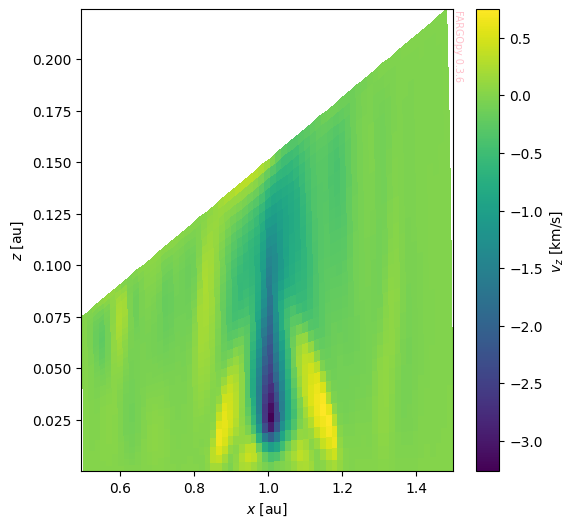

In [82]:
fig,axs = plt.subplots(1,1,figsize=(6,6))

cmap = 'viridis'
ax = axs

# Heat map of the vertical component of velocity
c = ax.pcolormesh(mesh.x*sim.UL/fp.AU,mesh.z*sim.UL/fp.AU,gasvz_planet*sim.UV/(1e5),cmap=cmap)
cbar = fig.colorbar(c)
cbar.set_label('$v_z$ [km/s]')

ax.set_xlabel('$x$ [au]')
ax.set_ylabel('$z$ [au]')
fp.Util.fargopy_mark(ax)

Now, we want to create a vector field of the velocity, superimposed to the gas density field.  We need to load the `gasdens` field and slice it:

In [83]:
gasd = sim.load_field('gasdens',snapshot=10,type='scalar')
gasd_slice,mesh = gasd.meshslice(slice='phi=0')

We also need to slice all the components of the velocity field:

In [84]:
gasvx_slice,mesh = gasvx.meshslice(slice='phi=0')
gasvy_slice,mesh = gasvy.meshslice(slice='phi=0')
gasvz_slice,mesh = gasvz.meshslice(slice='phi=0')

Now use `quiver` to plot the components of the velocity:

Text(1, 1, 'FARGOpy 0.3.6')

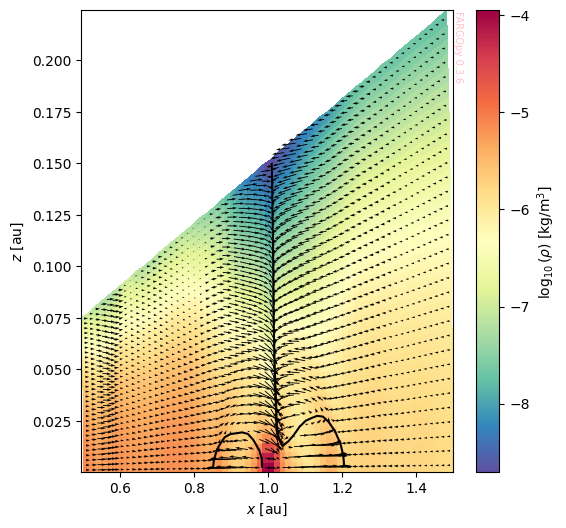

In [85]:
fig,axs = plt.subplots(1,1,figsize=(6,6))

cmap = 'Spectral_r'

# Colormap of the logaritmic density
pc = axs.pcolormesh(mesh.x*sim.UL/fp.AU,mesh.z*sim.UL/fp.AU,np.log10(gasd_slice*sim.URHO*1e3),cmap=cmap)
cbar = fig.colorbar(pc)
cbar.set_label(r'$\log_{10}(\rho)$ [kg/m$^3$]')

# Line of vx = 0 velocity (vertical motion of the gas)
c = axs.contour(mesh.x*sim.UL/fp.AU,mesh.z*sim.UL/fp.AU,gasvx_slice,levels=0,colors='k')

# Show the velocity field
freq = 1
axs.quiver(mesh.x[::freq,::freq]*sim.UL/fp.AU,
           mesh.z[::freq,::freq]*sim.UL/fp.AU,
           gasvx_slice[::freq,::freq],
           gasvz_slice[::freq,::freq],
           scale=2)
axs.set_xlabel('$x$ [au]')
axs.set_ylabel('$z$ [au]')
fp.Util.fargopy_mark(axs)

### Animating the velocity field

Now we can attempt to animate the velocity field evolution. For that purpose we use the methods found in the [animation tutorial](). For that purpose we need to load the fields at all snapshots:

In [88]:
gasdens_all = sim.load_allfields('gasdens')
gasv_all = sim.load_allfields('gasv',type='vector')

In [103]:
plt.ioff()
fig,axs = plt.subplots(1,1,figsize=(6,6))
cmap = 'Spectral_r'
camera = Camera(fig)

axs.set_xlabel('$x$ [au]')
axs.set_ylabel('$z$ [au]')
fp.Util.fargopy_mark(axs)

for snapshot in tqdm(gasdens_all.snapshots):
    gasd = gasdens_all.item(str(snapshot)).gasdens
    gasd_slice,mesh = gasd.meshslice(slice='phi=0')

    gasv = gasv_all.item(str(snapshot)).gasv
    gasvx, gasvy, gasvz = gasv.to_cartesian()
    gasvx_slice,mesh = gasvx.meshslice(slice='phi=0')
    gasvy_slice,mesh = gasvy.meshslice(slice='phi=0')
    gasvz_slice,mesh = gasvz.meshslice(slice='phi=0')

    # Colormap of the logaritmic density
    pc = axs.pcolormesh(mesh.x*sim.UL/fp.AU,mesh.z*sim.UL/fp.AU,np.log10(gasd_slice*sim.URHO*1e3),cmap=cmap)
    
    # Show the velocity field
    freq = 1
    axs.quiver(mesh.x[::freq,::freq]*sim.UL/fp.AU,
            mesh.z[::freq,::freq]*sim.UL/fp.AU,
            gasvx_slice[::freq,::freq],
            gasvz_slice[::freq,::freq],
            scale=2)

    camera.snap()

plt.ion()
animation = camera.animate(interval=100,blit=True)
animation.save('figures/p3disoj.gif',fps=5)


  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 12.25it/s]


Visualize it:

In [102]:
HTML(animation.to_html5_video())